<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/DataFrameMakerCRY5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
#%pip -q install matplotlib

import matplotlib.pyplot as plt
#%pip -q install uproot
#%pip -q install --upgrade tables
#%pip -q install pandas
import uproot
import pandas as pd
import numpy as np
import XRootD

# Init and define function

In [24]:
DATASET='CRY5mixed'

if DATASET=='CRY5mixed':
    h5file='~/test_load/trk.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0.h5'
    files_root={  
        'root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/users/dzhadan/workflow/CRY5/nts.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0.tka' : [17000, 1] 
    }
elif DATASET=='CE1B':
    h5file='drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix1BBSignal.MDC2020r_perfect_v1_0.h5'
    files_root={                  
      'drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix1BBSignal.MDC2020r_perfect_v1_0.root': [17000, -1],
    }
elif DATASET=='CE2B':
    h5file='drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix2BBSignal.MDC2020r_perfect_v1_0.h5'
    files_root={                  
      'drive/MyDrive/root_files_cry5/trk.mu2e.CeEndpointMix2BBSignal.MDC2020r_perfect_v1_0.root': [17000, -1],
    }
else:
    raise ValueError('Unknown dataset')

In [18]:
def make_df(trkana, tag_high, lyield):
    df_crv = trkana.arrays(filter_name='debestcrv/*',library="pd")
    df_crv.columns = df_crv.columns.str.replace('_', 'crvinfo_')
    df_ = trkana.arrays(filter_name='debestcrvmc/*',library="pd")
    df_.columns = df_.columns.str.replace('_', 'crvinfomc_')
    df_crv = df_crv.merge(df_, left_index=True, right_index=True)

    df_ = trkana.arrays(filter_name='dequal*',library="pd")
    df_.columns = df_.columns.droplevel()
    df_ = df_.add_prefix('dequal_')
    df_crv = df_crv.merge(df_, left_index=True, right_index=True)

    df_ = trkana.arrays(filter_name='detrkpid*',library="pd")
    df_.columns = df_.columns.droplevel()
    df_ = df_.add_prefix('detrkpid_')
    df_crv = df_crv.merge(df_, left_index=True, right_index=True)

    df_eve = trkana.arrays(filter_name=['evtinfo.*', 'evtinfomc.*', 'de.*', 'deent*', 'demc.*', 'demcgen.*', 'demcpri.*', 'ue.*', 'crvsummary.*', 'crvsummarymc.*'],library="pd")
    df_eve.columns = df_eve.columns.str.replace('.', '_')
    df_eve.columns = df_eve.columns.str.replace('_fCoordinates_f', '')
    df_eve["deent_mom"] = pow(pow(df_eve["deent_momX"],2) + pow(df_eve["deent_momY"],2) + pow(df_eve["deent_momZ"],2),0.5)
    df_eve["demcpri_mom"] = pow(pow(df_eve["demcpri_momX"],2) + pow(df_eve["demcpri_momY"],2) + pow(df_eve["demcpri_momZ"],2),0.5)

    df = df_crv.merge(df_eve, left_index=True, right_index=True)
    df['is_high'] = tag_high
    df['lyield'] = int(lyield)
    df["crvinfo_dT"] = df["crvinfo_timeWindowStart"] - df["de_t0"]
    df["crvinfo_dTe"] = df["crvinfo_timeWindowEnd"] - df["de_t0"]
    df = df.fillna(-999999)
    return df

In [17]:
def combine_df(files):
    
    df = pd.DataFrame()
    for f in files:
        print("Reading file", f, files[f][0], files[f][1])
        trkana = uproot.open(f+":TrkAnaNeg/trkana")
        df_ = make_df(trkana, files[f][1], files[f][0])
        df_ = df_.filter(regex=var_str)
        df = df.append(df_)
    df = df.loc[:,~df.columns.duplicated()]  # delete duplicate colummns
    return df 

#Variables list to save in df

In [14]:
var_list=[
 'evtinfo_eventid',
 'evtinfo_subrunid',
 'evtinfomc_nprotons',
 'de_status',
 'de_pdg',
 'de_nhits',
 'de_t0',
 'deent_mom',
 'deent_d0',
 'deent_p0',
 'deent_z0',
 'deent_td',
 'dequal_TrkPID',
 'dequal_TrkQual',
 'detrkpid',
 'demc_pdg',
 'demc_gen',
 'demcgen_pdg',
 'demcgen_gen',
 'demcgen_posx',
 'demcgen_posy',
 'demcgen_posz',
 'demcgen_momx',
 'demcgen_momy',
 'demcgen_momz',
 'demcpri_posX',
 'demcpri_posY',
 'demcpri_posZ',
 'demcpri_posZ',
 'demcpri_pdg',
 'demcpri_mom',
 'trigbits',
 'ue_status',
 'ue_nhits',
 '_totalPEs',
 '_nHitCounters',
 '_totalEnergyDeposited',
 '_x',
 '_y',
 '_z',
 '_pdgId',
 '_crvSectorNumber',
 '_crvSectorType',
 'crvsummary_totalPEs',
 'crvsummary_nHitCounters',
 'crvsummarymc_totalEnergyDeposited',
 'crvsummarymc_x',
 'crvsummarymc_y',
 'crvsummarymc_z',
 'crvsummarymc_pdgId',
 'crvsummarymc_crvSectorNumber',
 'crvsummarymc_crvSectorType',
 'crvinfo_crvSectorType',
 'crvinfo_x',
 'crvinfo_y',
 'crvinfo_z',
 'crvinfo_PEs',
 'crvinfo_timeWindowStart',
 'crvinfo_timeWindowEnd',
 'crvinfo_angle',
 'crvinfo_nCoincidenceHits',
 'crvinfo_nCoincidenceLayers',
 'crvinfomc',
 'bestcrv',
 'is_high',
 'lyield',
 'crvinfo_dT',
 'crvinfo_dTe',
 'deent_maxr',
 'is_triggered']

var_str='('
for var in var_list:
    if var == "detrkpid":
        var_str=var_str+var+'|'
    elif var == 'crvinfomc':
        var_str=var_str+var+'|'
    else: 
        var_str=var_str+var+'$|'

var_str=var_str[:-1]+')'

# Save dataframe

In [19]:
df = combine_df(files_root)
df.to_hdf(h5file, key=DATASET)

Reading file root://fndca1.fnal.gov/pnfs/fnal.gov/usr/mu2e/scratch/users/dzhadan/workflow/CRY5/nts.mu2e.CosmicCRYhiSigFiltMix2BBSignal.MDC2020s_perfect_v1_0.tka 17000 1


/home/dzhadan/.conda/envs/XRootD/lib/python3.10/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/home/dzhadan/.conda/envs/XRootD/lib/python3.10/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/home/dzhadan/.conda/envs/XRootD/lib/python3.10/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

#Load dataframe

In [20]:
df = pd.read_hdf(h5file, mode='r', key=DATASET).query('lyield==17000')

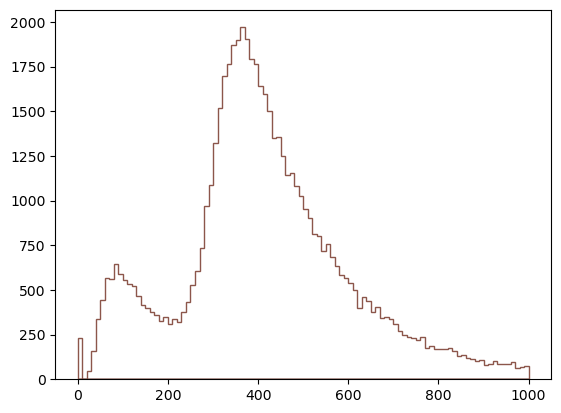

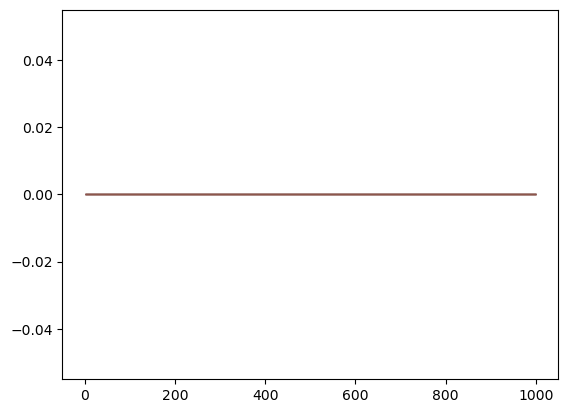

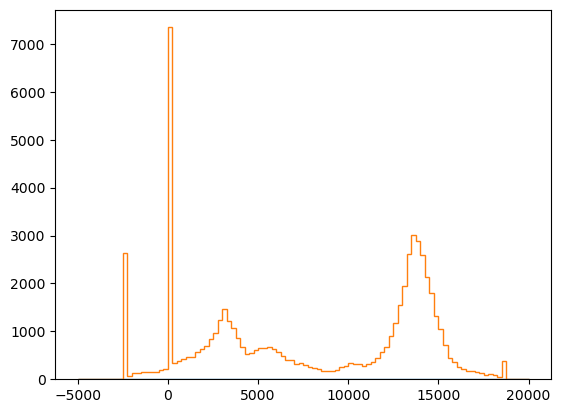

In [21]:
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==1 & lyield==%i' % l)['crvinfo_PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==0 & lyield==%i' % l)['crvinfo_PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
plt.hist(df.query('is_high==0 & lyield==%i' % 17000)['crvinfomc_z'], bins=100, range=(-5000, 20000), histtype='step');
plt.hist(df.query('is_high==1 & lyield==%i' % 17000)['crvinfomc_z'], bins=100, range=(-5000, 20000), histtype='step');

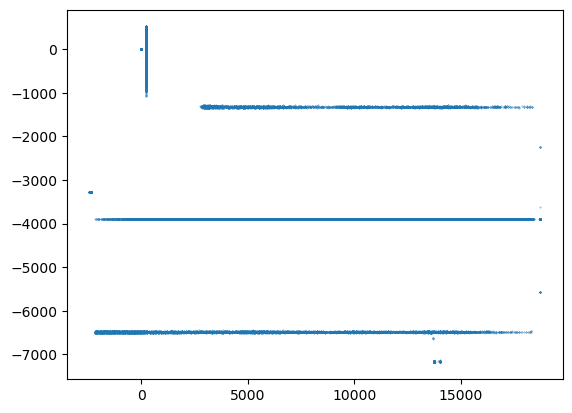

In [23]:
cut_tmp = 'lyield==%i' % 17000
plt.plot(df.query(cut_tmp)['crvinfomc_z'], df.query(cut_tmp)['crvinfomc_x'], '.', markersize=0.5);